In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import librosa.display
import skimage.io
import os

In [2]:
PATH_0 = "../../birdclef-2022-data"
PATH_1 = "../../birdclef-2022-data"

DF_META = pd.read_csv(f"{PATH_1}/train_metadata.csv")

BASE_PATH = f'{PATH_1}/train_audio/'
AUDIO_NAME = f'{PATH_1}/train_audio/afrsil1/XC125458.ogg'
IMG_DIR = f'{PATH_1}/train_images_processed/'
HOP_LENGTH = 512
WINDOW_SIZE = 1024
N_MELS = 256

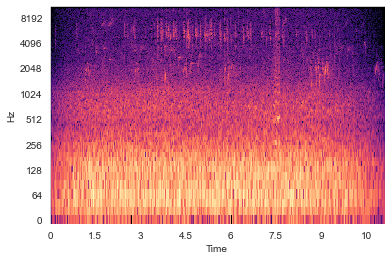

In [3]:
#Example: Create a spectrogram from ogg.-file with librosa

y, sr = librosa.load(AUDIO_NAME)
window = np.hanning(WINDOW_SIZE)
out  = librosa.core.spectrum.stft(y, n_fft = WINDOW_SIZE, hop_length = HOP_LENGTH,
       window=window)
out = 2 * np.abs(out) / np.sum(window)

librosa.display.specshow(librosa.amplitude_to_db(out,ref=np.max),
               y_axis='log', x_axis='time')

In [4]:
# Functions to create spectrograms and the required folder structure for each label

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(IMG_DIR + out + '.png', img)

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def load_batch_spectograms(audio_names):
    for entry in audio_names:
        y, sr = librosa.load(BASE_PATH + entry)
        spectrogram_image(y, sr, entry[:-4], HOP_LENGTH, N_MELS)

# careful, takes multiple hours to run
def generate_spectograms():
    names = DF_META['filename']
    load_batch_spectograms(names)

def add_folder_structure():
    names = DF_META['primary_label'].unique()
    for name in names:
        os.mkdir(IMG_DIR + name)

In [5]:
add_folder_structure()

In [6]:
#generate_spectograms()